In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import transforms
from PIL import Image
convert_tensor = transforms.ToTensor()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
images = []
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        if filename.find(".jpg") != -1:
            if random.random() > 0.5:
                images.append(convert_tensor(Image.open(dirname + "/" + filename)))
images = torch.stack(images)
print(images.shape)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

torch.Size([3714, 3, 256, 256])


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
images = images.view(images.shape[0], -1).to(device)

In [4]:
import torch.nn as nn

In [5]:
class GAN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.picasso = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
        self.critic = nn.Sequential(
            nn.Linear(out_size, 1),
            nn.Sigmoid()
        )
    def forward(self, ins):
        return self.picasso(ins)
    def gan_forward(self, ins):
        return self.critic(ins)
    def __call__(self, ins):
        return self.forward(ins)

In [6]:
net = GAN(10, 200, 3 * 256 * 256).to(device)

In [7]:
net.gan_forward(net(torch.randn(10).to(device)))

tensor([0.5968], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [8]:
num_epochs = 2
batch_size = 2
train_len = len(images)
num_steps = (train_len//batch_size) * num_epochs
lr = 0.0001
optimG = torch.optim.AdamW(net.picasso.parameters(), lr=lr)
optimD = torch.optim.SGD(net.critic.parameters(), lr=lr)

In [9]:
for step in range(num_steps):
    d_batch_real = images[torch.randint(1, train_len-1, (batch_size//2,))]
    d_batch_gen = net(torch.randn(batch_size//2, 10).to(device))
    d_batch = torch.cat((d_batch_real, d_batch_gen)).to(device)
    d_ys = torch.cat((torch.zeros(batch_size//2, 1), torch.ones(batch_size//2, 1))).to(device)
    d_out = net.gan_forward(d_batch)
    
    d_loss = nn.functional.binary_cross_entropy(d_out, d_ys)
    optimD.zero_grad()
    d_loss.backward()
    optimD.step()
    
    
    g_batch = torch.randn(batch_size, 10).to(device)
    g_out = net(g_batch)
    
    g_loss = net.gan_forward(g_out).sum() / len(g_out)
    optimG.zero_grad()
    g_loss.backward()
    optimG.step()
    
    if step % 100 == 0:
        print("Step", str(step) + ", loss D:", str(d_loss.item()) + ", loss G:", g_loss.item())

Step 0, loss D: 0.7020347714424133, loss G: 0.5351425409317017
Step 100, loss D: 8.408099174499512, loss G: 0.12735633552074432
Step 200, loss D: 3.9330105781555176, loss G: 0.49951496720314026
Step 300, loss D: 3.324705123901367, loss G: 0.9129093885421753
Step 400, loss D: 0.2992745041847229, loss G: 0.4136713445186615
Step 500, loss D: 3.456198215484619, loss G: 0.3803832232952118
Step 600, loss D: 0.5698534250259399, loss G: 0.24097518622875214
Step 700, loss D: 0.8923534750938416, loss G: 0.507282018661499
Step 800, loss D: 0.7254099249839783, loss G: 0.7887670397758484
Step 900, loss D: 0.7845323085784912, loss G: 0.6304897665977478
Step 1000, loss D: 0.33084264397621155, loss G: 0.6859738230705261
Step 1100, loss D: 0.371204137802124, loss G: 0.637391209602356
Step 1200, loss D: 0.6296112537384033, loss G: 0.548494279384613
Step 1300, loss D: 1.1739251613616943, loss G: 0.5724769830703735
Step 1400, loss D: 0.6157112717628479, loss G: 0.48641619086265564
Step 1500, loss D: 0.424

In [10]:
import torchvision

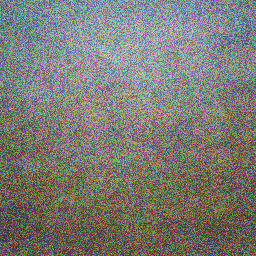

In [11]:
with torch.no_grad():
    ins = torch.randn(10).to(device)
    net_out = net(ins).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(net_out)
    display(image)